# Project Introduction
This project aims to develop a scheduling system using constraint programming techniques. The primary objective is to efficiently allocate resources and schedule tasks while adhering to various constraints such as precedence relations and resource availability. The project leverages the OR-Tools library to model and solve the scheduling problem, ensuring optimal task sequencing and resource utilization.

### Team Members
Mario Pinto - Student Number: 23506
Renato Silva - Student Number: 23511

Jobs:
Job: {'job_id': 1, 'successors': [2, 3, 4], 'resources': [0, 0, 0, 0], 'duration': 0}
Job: {'job_id': 2, 'successors': [23, 24], 'resources': [0, 0, 0, 5], 'duration': 1}
Job: {'job_id': 3, 'successors': [5, 6, 17], 'resources': [0, 3, 0, 0], 'duration': 1}
Job: {'job_id': 4, 'successors': [7, 20], 'resources': [8, 0, 0, 0], 'duration': 1}
Job: {'job_id': 5, 'successors': [10, 22, 28], 'resources': [0, 0, 2, 0], 'duration': 7}
Job: {'job_id': 6, 'successors': [18], 'resources': [0, 0, 0, 3], 'duration': 6}
Job: {'job_id': 7, 'successors': [8, 9, 12], 'resources': [1, 0, 0, 0], 'duration': 4}
Job: {'job_id': 8, 'successors': [14, 21, 27], 'resources': [0, 0, 10, 0], 'duration': 5}
Job: {'job_id': 9, 'successors': [11, 16], 'resources': [0, 0, 3, 0], 'duration': 8}
Job: {'job_id': 10, 'successors': [16], 'resources': [0, 0, 0, 1], 'duration': 7}
Job: {'job_id': 11, 'successors': [17], 'resources': [9, 0, 0, 0], 'duration': 8}
Job: {'job_id': 12, 'successors': [13, 15, 16], 'resourc

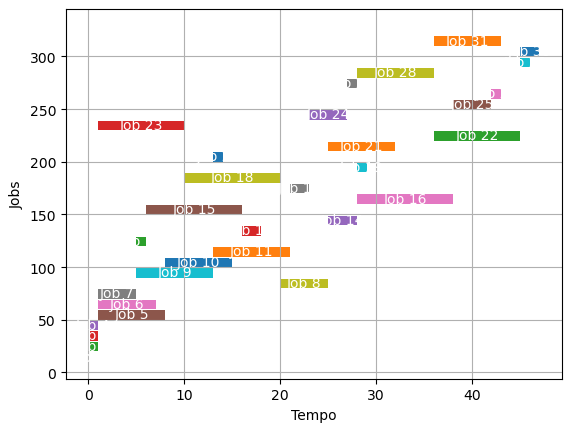

In [2]:
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model

# Passo 1: Ler o Arquivo
def read_file(filename):
    jobs = []
    resources = {}
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        
        # Parsing das relações de precedência
        precedence_section = False
        for line in lines:
            if line.startswith("#Precedence relations"):
                precedence_section = True
                continue  # Pular o cabeçalho da seção
            elif line.startswith("#Duration and resources"):
                precedence_section = False
                break
            elif precedence_section and line.strip() and not line.startswith("#") and not line.startswith("*"):
                precedence_data = line.strip().split()
                if precedence_data[0].isdigit():
                    job_id = int(precedence_data[0])
                    successors = list(map(int, precedence_data[3:]))
                    # Adicionar job apenas com sucessores e recursos vazios
                    jobs.append({"job_id": job_id, "successors": successors, "resources": [], "duration": 0})

        # Parsing dos jobs (apenas recursos)
        job_section = False
        for line in lines:
            if line.startswith("#Duration and resources"):
                job_section = True
                continue  # Pular o cabeçalho da seção
            elif line.startswith("#Resource availability"):
                job_section = False
                break
            elif job_section and line.strip() and not line.startswith("#") and not line.startswith("*"):
                job_data = line.strip().split()
                if job_data[0].isdigit():
                    job_id = int(job_data[0])
                    duration = int(job_data[2])
                    resource_requirements = list(map(int, job_data[3:]))
                    # Atualizar os dados do job
                    for job in jobs:
                        if job["job_id"] == job_id:
                            job["resources"] = resource_requirements
                            job["duration"] = duration
                            break

        # Parsing da disponibilidade de recursos
        resource_section = False
        for line in lines:
            if line.startswith("#Resource availability"):
                resource_section = True
                continue  # Pular o cabeçalho da seção
            elif resource_section and line.strip() and not line.startswith("#") and not line.startswith("*"):
                resource_data = line.strip().split()
                if len(resource_data) == 2 and resource_data[0].startswith("R"):
                    resource_id = resource_data[0]  # Manter o ID do recurso como string (ex: "R1")
                    quantity = int(resource_data[1])
                    resources[resource_id] = quantity

    return jobs, resources

# Passo 2: Criar Variáveis + Domínio
def create_variables(jobs, resources, model):
    job_vars = {}
    job_ends = []
   
    horizon = sum(job["duration"] for job in jobs) * 2  # Aumentar o horizonte para evitar inviabilidade
    for job in jobs:
        job_id = job["job_id"]
        duration = job["duration"]
        start_var = model.NewIntVar(0, horizon, f'start_{job_id}')
        end_var = model.NewIntVar(0, horizon, f'end_{job_id}')
        interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job_id}')
        job_vars[job_id] = (start_var, end_var, interval_var)
        job_ends.append(end_var)
    return job_vars, job_ends, horizon

# Passo 3: Aplicar Restrições - Precedências
def apply_precedence_constraints(jobs, job_vars, model):
    for job in jobs:
        job_id = job["job_id"]
        successors = job["successors"]
        if job_id == 1:
            # Garantir que o Job 1 comece no tempo 0
            model.Add(job_vars[job_id][0] == 0)
            print(f'Adicionada restrição: job {job_id} começa no tempo 0')
        for successor in successors:
            if successor in job_vars and job_id != successor:  # Garantir que o sucessor existe em job_vars e não é o mesmo job
                model.Add(job_vars[job_id][1] <= job_vars[successor][0])
                print(f'Adicionada restrição de precedência: job {job_id} (fim: {job_vars[job_id][1]}) termina antes do job {successor} (início: {job_vars[successor][0]}) começar')

# Passo 4: Aplicar Restrições - Recursos
def apply_resource_constraints(jobs, resources, job_vars, model):
    resource_intervals = {resource: [] for resource in resources}
    demands = {resource: [] for resource in resources}
    for job in jobs:
        job_id = job["job_id"]
        resource_requirements = job["resources"]
        for resource_id, required_quantity in enumerate(resource_requirements, start=1):
            resource_key = f"R{resource_id}"
            if resource_key in resources and required_quantity > 0:
                resource_intervals[resource_key].append(job_vars[job_id][2])
                demands[resource_key].append(required_quantity)
    for resource, intervals in resource_intervals.items():
        if intervals:
            print(f'Recursos {resource} intervalos: {intervals}')
            print(f'Recursos {resource} demandas: {demands[resource]}')
            model.AddCumulative(intervals, demands[resource], resources[resource])
            print(f'Adicionada restrição cumulativa para o recurso {resource} com capacidade {resources[resource]}')

# Passo 5: Escolher a Melhor Solução - Preferências/Heurística
def solve_model(model, job_vars, job_ends, horizon):
    # Minimizar o makespan (tempo de término do último job)
    makespan = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(makespan, job_ends)
    model.Minimize(makespan)
    
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    
    # Imprimir o status do solver
    print(f'Status do solver: {solver.StatusName(status)}')
    
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        solution = {job_id: (solver.Value(vars[0]), solver.Value(vars[1])) for job_id, vars in job_vars.items()}
        return solution, solver.ObjectiveValue()
    else:
        # Imprimir informações de inviabilidade
        print('Análise de inviabilidade:')
        print(solver.ResponseStats())
        return None, None

# Passo 6: Criar Gráfico Matplot da Sequência
def plot_schedule(solution):
    print(solution)
    if solution:
        fig, gnt = plt.subplots()
        gnt.set_xlabel('Tempo')
        gnt.set_ylabel('Jobs')
        gnt.grid(True)
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        for job_id, (start, end) in solution.items():
            print(job_id)
            color = colors[job_id % len(colors)]
            gnt.broken_barh([(start, end - start)], (job_id * 10, 9), facecolors=(color))
            gnt.text(start + (end - start) / 2, job_id * 10 + 5, f'Job {job_id}', ha='center', va='center', color='white')
        plt.show()

def check_resource_usage(jobs, resources, job_vars, model):
    for resource_id, capacity in resources.items():
        print(f'Capacidade do recurso {resource_id}: {capacity}')
    for job in jobs:
        job_id = job["job_id"]
        start_var, end_var, interval_var = job_vars[job_id]
        print(f'Job {job_id} usa recursos {job["resources"]} de {start_var} a {end_var}')

# Função Principal
def main():
    filename = 'teste3.txt'  # Especifique o nome do seu arquivo .txt aqui
    jobs, resources = read_file(filename)

    # Imprimir informações detalhadas dos jobs
    print("Jobs:")
    for job in jobs:
        print("Job:", job)
    print("Recursos:")
    for resource_id, capacity in resources.items():
        print(f'Recurso {resource_id}: {capacity}')

    # Criar modelo
    model = cp_model.CpModel()

    # Criar Variáveis + Domínio
    job_vars, job_ends, horizon = create_variables(jobs, resources, model)

    # Aplicar Restrições - Precedências
    apply_precedence_constraints(jobs, job_vars, model)

    # Aplicar Restrições - Recursos
    apply_resource_constraints(jobs, resources, job_vars, model)
    
    # Verificar uso de recursos para depuração
    check_resource_usage(jobs, resources, job_vars, model)
    
    # Resolver Modelo
    solution, objective = solve_model(model, job_vars, job_ends, horizon)
    if solution:
        print(f'Valor do objetivo: {objective}')
        for job_id, (start, end) in solution.items():
            print(f'Job {job_id} começa em {start} e termina em {end}')
    else:
        print('Nenhuma solução viável encontrada.')

    # Plotar cronograma
    plot_schedule(solution)

if __name__ == '__main__':
    main()